# Integrated gradients for MNIST

In this notebook we apply the integrated gradients method to a convolutional network trained on the MNIST dataset. 
Integrated gradients defines an attribution value for each feature of the input instance (in this case for each pixel in the image) by integrating the model's gradients with respect to the input along a straight path from a baseline instance $x^\prime$ to the input instance $x.$

A more detailed description of the method can be found [here](https://docs.seldon.io/projects/alibi/en/stable/methods/IntegratedGradients.html). Integrated gradients was originally proposed in Sundararajan et al., ["Axiomatic Attribution for Deep Networks"](https://arxiv.org/abs/1703.01365).

<div class="alert alert-info">
Note
    
To enable support for IntegratedGradients, you may need to run
    
```bash
pip install alibi[tensorflow]
```

</div>

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # True

2023-12-06 10:10:15.358734: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 10:10:15.687746: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 10:10:17.007740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/xchen/miniconda3/envs/deepjanus-pri/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as 

TF version:  2.12.1
Eager execution enabled:  True


## Load data

Loading and preparing the MNIST data set.

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test
test_labels = y_test.copy()
train_labels = y_train.copy()
                         
X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


## Train model

Train a convolutional neural network on the MNIST dataset. The model includes 2 convolutional layers and it reaches a test accuracy of 0.98. If `save_model = True`, a local folder `./model_mnist` will be created and the trained model will be saved in that folder. If the model was previously saved, it can be loaded by setting `load_mnist_model = True`.

In [3]:
load_mnist_model = False
save_model = True

In [4]:
"""filepath = './model_mnist/'  # change to directory where model is saved
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=6,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if save_model:
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        model.save(os.path.join(filepath, 'model.h5'))"""

"filepath = './model_mnist/'  # change to directory where model is saved\nif load_mnist_model:\n    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))\nelse:\n    # define model\n    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)\n    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)\n    x = MaxPooling2D(pool_size=2)(x)\n    x = Dropout(.3)(x)\n    \n    x = Conv2D(32, 2, padding='same', activation='relu')(x)\n    x = MaxPooling2D(pool_size=2)(x)\n    x = Dropout(.3)(x)\n    \n    x = Flatten()(x)\n    x = Dense(256, activation='relu')(x)\n    x = Dropout(.5)(x)\n    logits = Dense(10, name='logits')(x)\n    outputs = Activation('softmax', name='softmax')(logits)\n    model = Model(inputs=inputs, outputs=outputs)\n    model.compile(loss='categorical_crossentropy',\n                  optimizer='adam',\n                  metrics=['accuracy'])\n    \n    # train model\n    model.fit(X_train,\n              y_train,\n              epochs=6,\n   

## Calculate integrated gradients

The IntegratedGradients class implements the integrated gradients attribution method. A description of the method can be found [here](https://docs.seldon.io/projects/alibi/en/stable/methods/IntegratedGradients.html).

In the following example, the baselines (i.e. the starting points of the path integral) are black images (all pixel values are set to zero). This means that black areas of the image will always have zero attribution.
The path integral is defined as a straight line from the baseline to the input image. The path is approximated by choosing 50 discrete steps according to the Gauss-Legendre method.

In [5]:
# Initialize IntegratedGradients instance
import keras
n_steps = 20
model = keras.models.load_model('models/cnnClassifier.h5')
method = "gausslegendre"
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method)

2023-12-06 10:10:23.557512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 10:10:23.845772: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-06 10:10:23.846130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [6]:
# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_sample = X_test[:nb_samples]
print(1)
predictions = model(X_test_sample).numpy().argmax(axis=1)
print(2)
explanation = ig.explain(X_test_sample, 
                         baselines=None, 
                         target=predictions)

1


2023-12-06 10:10:27.723833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8906
2023-12-06 10:10:28.483975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-06 10:10:28.547169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [200]
	 [[{{node Placeholder/_1}}]]


2


In [7]:
# Metadata from the explanation object
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'target_fn': None,
  'method': 'gausslegendre',
  'n_steps': 20,
  'internal_batch_size': 100,
  'layer': 'unspecified'},
 'version': '0.9.4'}

In [8]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'forward_kwargs', 'baselines', 'predictions', 'deltas', 'target'])

In [9]:
# Get attributions values from the explanation object
attrs = explanation.attributions[0]

## Visualize attributions

Sample images from the test dataset and their attributions.

* The first column shows the original image. 
* The second column shows the values of the attributions.
* The third column shows the positive valued attributions.
* The fourth column shows the negative valued attributions.

The attributions are calculated using the black image as a baseline for all samples.

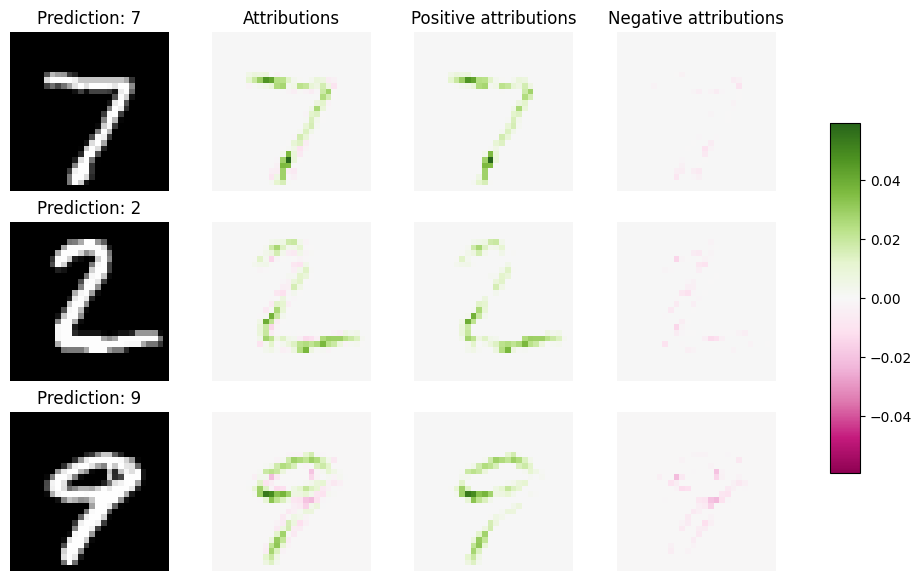

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(10, 7))
image_ids = [0, 1, 9]
cmap_bound = np.abs(attrs[[0, 1, 9]]).max()
# attrs = attrs.clip(0, 1)
for row, image_id in enumerate(image_ids):
    # original images
    ax[row, 0].imshow(X_test[image_id].squeeze(), cmap='gray')
    ax[row, 0].set_title(f'Prediction: {predictions[image_id]}')
    
    # attributions
    attr = attrs[image_id]
    im = ax[row, 1].imshow(attr.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
    # positive attributions
    attr_pos = attr.clip(0, 1)
    im_pos = ax[row, 2].imshow(attr_pos.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
    # negative attributions
    attr_neg = attr.clip(-1, 0)
    im_neg = ax[row, 3].imshow(attr_neg.squeeze(), vmin=-cmap_bound, vmax=cmap_bound, cmap='PiYG')
    
ax[0, 1].set_title('Attributions');
ax[0, 2].set_title('Positive attributions');
ax[0, 3].set_title('Negative attributions');

for ax in fig.axes:
    ax.axis('off')

fig.colorbar(im, cax=fig.add_axes([0.95, 0.25, 0.03, 0.5]));

Loaded model from disk
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
{'name': 'IntegratedGradients', 'type': ['whitebox'], 'explanations': ['local'], 'params': {'target_fn': None, 'method': 'gausslegendre', 'n_steps': 10, 'internal_batch_size': 100, 'layer': 'unspecified'}, 'version': '0.9.4'}
(10, 28, 28)


2023-12-06 10:10:32.364467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [100]
	 [[{{node Placeholder/_1}}]]


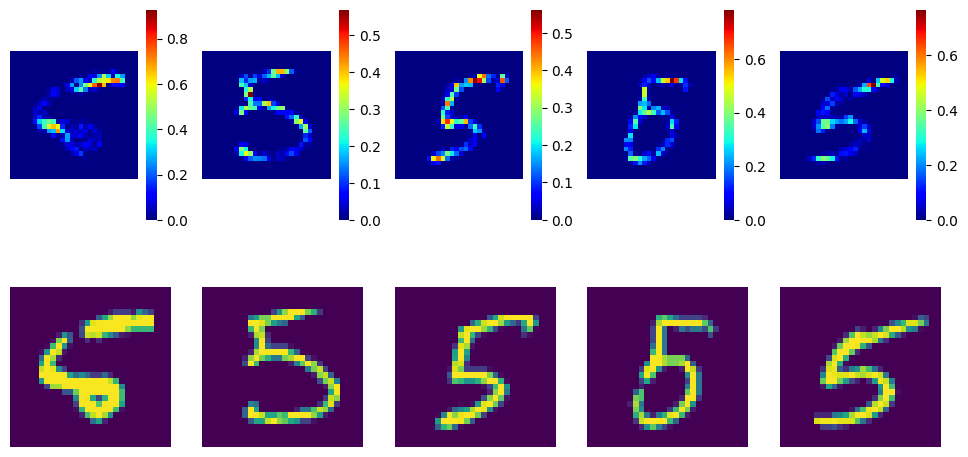

In [11]:
from population import load_mnist_test
import seaborn as sns
%matplotlib inline
# data
test_x, test_y = load_mnist_test(popsize=10, number=5)

X_test = test_x.reshape(-1, 28, 28, 1).astype('float64') / 255
y_test = to_categorical(test_y, 10)

import keras
n_steps = 10
model = keras.models.load_model('models/cnnClassifier.h5')
method = "gausslegendre"
ig = IntegratedGradients(model,
                          n_steps=n_steps,
                          method=method)

# Calculate attributions for the first 10 images in the test set
nb_samples = 50
X_test_sample = X_test[:nb_samples]
predictions = [5, 5, 5, 5, 5, 5, 5, 5 ,5, 5]#model(X_test_sample).numpy().argmax(axis=1)
print(predictions)
explanation = ig.explain(X_test_sample,
                         baselines=None,
                         target=predictions)

print(explanation.meta)
"""
Metadata from the explanation object
{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'target_fn': None,
  'method': 'gausslegendre',
  'n_steps': 50,
  'internal_batch_size': 100,
  'layer': 'unspecified'},
 'version': '0.9.4'}
"""
attrs = np.array(explanation.attributions[0])
#attrs = attrs.clip(0, 1)
attrs = np.abs(attrs)
attrs = attrs.squeeze()
print(attrs.shape)



# Normalization
try:
    normalized_attributions = (attrs - np.min(attrs)) / (np.max(attrs) - np.min(attrs))
except ZeroDivisionError:
    print("Error: Cannot divide by zero")
    

import seaborn as sns

rows = 2
popsize = 5
f, ax = plt.subplots(nrows=rows, ncols=popsize, figsize=(12, 6))

row = 0
for i in range(popsize):
    sns.heatmap(normalized_attributions[i], ax=ax[row, i], square=True, cmap="jet")
    #ax[row, i].imshow(saliency_map[i], cmap="jet")
    ax[row, i].axis('off')

row += 1
for i in range(popsize):

    ax[row, i].imshow(X_test_sample[i])
    #ax[row, i].imshow(normalized_attributions[i], cmap='jet', alpha=0.6)
    ax[row, i].axis('off')

In [21]:
def cluster_attention_map(map, control_points, weight_threshold=0.1):
    control_points = np.array(control_points)
    centroids = np.zeros(control_points.shape)
    centroids[:, 0] = control_points[:, 1]
    centroids[:, 1] = control_points[:, 0]

    num_rows = 28
    num_cols = 28
    points = np.array([(i, j) for i in range(num_rows) for j in range(num_cols)])
    weights = map.flatten()
    # print(weights)

    # use euclidean distance to cluster heatmap
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    distances_to_centroid = np.min(distances, axis=0)
    clustered_points = np.argmin(distances, axis=0)
    clustered_points[weights<weight_threshold] = -1
    # points = np.array([(i,j) for i in range(num_rows) for j in range(num_cols)])
    # clustered_points = clustered_points.reshape(num_rows, num_rows)

    # compute the weights
    new_centroids = np.zeros(centroids.shape)
    centroids_weight = np.zeros(centroids.shape[0])
    for i in range(centroids.shape[0]):
        points_in_cluster = points[clustered_points == i]
        
        weights_in_cluster = weights[clustered_points == i]

        new_centroids[i] = np.sum(points_in_cluster.T*weights_in_cluster, axis=1)/np.sum(weights_in_cluster)
        #print(f"new_centroid {new_centroids[i]}")
        
        distances_in_cluster = distances_to_centroid[clustered_points == i]

        distances_in_cluster[distances_in_cluster < 1] = 1

        weights_in_cluster = np.multiply(weights_in_cluster, 1. / np.power(distances_in_cluster, 1))

        centroids_weight[i] = np.sum(weights_in_cluster)
        # print(f"centroids_weight {i} {centroids_weight[i]}")

        # softmax
    weight_list = np.exp(centroids_weight / np.sum((centroids_weight), axis=0) *30)
    directions = new_centroids-control_points
    for i, dir in enumerate(directions):
        dir_norm = np.linalg.norm(dir)
        print(dir_norm)
        directions[i] = np.array([0,0]) if dir_norm==0 or np.isnan(dir_norm) else dir/dir_norm 
    return clustered_points, weight_list, new_centroids



In [22]:
from population import generate_digit, load_mnist_test
from mutation_manager import end_or_middle_points
from digit_mutator import DigitMutator

id = 1
number = 5
ind = generate_digit(id, test_x[id], number)
mutator = DigitMutator(ind)

# gather all candidates to be mutated
control_points = end_or_middle_points(mutator.svg_path, "end")

control_points = np.array(control_points)
print(control_points)

[[ 8.75       23.43710558]
 [13.25       21.74703535]
 [16.72766356 13.68989185]
 [10.96092529 13.02091215]
 [ 8.97994402 11.52416597]
 [ 8.96482636  8.45761836]
 [15.07657533  4.49119243]
 [20.5         4.03553552]
 [15.75        5.57589208]
 [11.          9.05812433]
 [13.35211678 11.        ]
 [23.39229056 17.23610305]
 [14.91722902 23.65876545]
 [ 8.75       23.43710558]]


/tmp/ipykernel_50238/250063463.py:29: RuntimeWarning: invalid value encountered in divide
  new_centroids[i] = np.sum(points_in_cluster.T*weights_in_cluster, axis=1)/np.sum(weights_in_cluster)


19.444239008077496
13.311026925690198
5.612199917989605
2.0973222885907767
3.962726264444552
2.001173078824633
15.160816080826118
21.84287315353255
15.022173291842293
2.4031099471195865
3.565700228979831
7.858888103229782
9.327539518592518
nan
[19.99201075  2.22483652 11.32683928  2.34150196 40.92918044 48.46412879
 72.97139574  1.84834225  1.82441063 17.76607253 32.76331074 16.99548145
  1.87608639  1.        ]
[[21.75448033  8.9815903 ]
 [22.66543683 12.33783841]
 [13.28147159 18.11940072]
 [12.         11.19907667]
 [11.97604775  8.93060435]
 [ 7.08536118  9.14486238]
 [ 4.36792129 15.22315744]
 [ 4.         18.34850542]
 [ 5.0373947  16.10707332]
 [ 9.03963228 10.44805087]
 [11.23951038 13.87247494]
 [16.94153246 21.7249606 ]
 [22.08173238 17.68608723]
 [        nan         nan]]


Text(0.5, 1.0, 'clustering map')

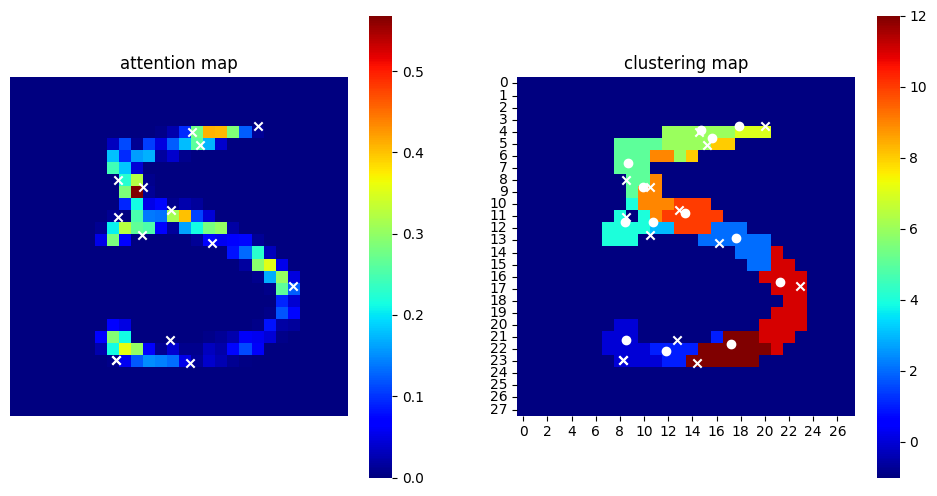

In [29]:
import mutation_manager
mutator.digit.attention = attrs[id]
clustered_points, weight_list, new_centroids = cluster_attention_map(mutator.digit.attention, control_points, weight_threshold=0.0001)

print(weight_list)
rows = 1
f, ax = plt.subplots(nrows=rows, ncols=2, figsize=(12, 6))


sns.heatmap(normalized_attributions[id], ax=ax[0], square=True, cmap="jet")
#ax[row, i].imshow(saliency_map[i], cmap="jet")
ax[0].axis('off')

ax[0].scatter(control_points[:,0],control_points[:,1], color="w", marker="x" )

ax[0].set_title("attention map")

new_centroids - control_points
print(new_centroids)

# cluster map
#ax[1].imshow(X[id])

clustered_points = clustered_points.reshape(28,28)

sns.heatmap(clustered_points,ax=ax[1], square=True,  alpha = 1,cmap="jet")
ax[1].scatter(control_points[:,0],control_points[:,1], color="w", marker="x" )
ax[1].scatter(new_centroids[:,1],new_centroids[:,0], color="w", marker="o" )
ax[1].set_title("clustering map")